### Import Libraries

In [1]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
# import joblib
from joblib import dump
# import joblib
from joblib import load

from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
# To sort dictionary values
import operator 
## Preprocessing
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import os


### Connect to Twitter

In [2]:
import tweepy
import config
    
# initialize api instance\n
consumer_key= config.consumer_key
consumer_secret= config.consumer_secret
access_token=config.access_token
access_token_secret =config.access_token_secret

#Connect to Twitter through the API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret) 
api = tweepy.API(auth,wait_on_rate_limit=True) 


### Get Twitter Trends

In [3]:
def get_trends_by_location(loc_id,count):
    '''Get Trending Tweets by Location'''
    import iso639
    import numpy as np
    from langdetect import detect
    df = pd.DataFrame([])
    try:
        trends = api.trends_place(loc_id)
        df = pd.DataFrame([trending['name'],  trending['tweet_volume'], iso639.to_name(detect(trending['name']))] for trending in trends[0]['trends'])
        df.columns = ['Trends','Volume','Language']
        #df = df.sort_values('Volume', ascending = False)
        return(df[:count])
    except Exception as e:
        pass
        print("An exception occurred: ",e)
        df = pd.DataFrame([trending['name'],  trending['tweet_volume'], np.nan] for trending in trends[0]['trends'])
        df.columns = ['Trends','Volume','Language']
        return(df[:count])
    

### Get Worldwide Twitter Trends

In [4]:
df_world_trends = get_trends_by_location(1, 20)
df_world_trends.head(2)

,Trends,Volume,Language
0,#KAI_1stSOLO,309128.0,Danish
1,#BETracklist,42719.0,German


### Get Translated Tweets

In [5]:
def get_translation(text):
    ''' Translate Tweets in English'''
    from googletrans import Translator  # Import Translator module from googletrans package
    try:
        translator = Translator() # Create object of Translator.
        translated = translator.translate(text,dest='en')
        return(translated.text)
    except Exception as e:
        print("Exception", e)
        return 'NA'

In [6]:
df_world_trends["Translated_Trends"] = [get_translation(val) for val in df_world_trends.Trends]
df_world_trends[["Trends","Language","Translated_Trends"]].head()

Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'


,Trends,Language,Translated_Trends
0,#KAI_1stSOLO,Danish,# KAI_1stSOLO
1,#BETracklist,German,NA
2,#IPLfinal,Italian,#IPLfinal
3,ポッキーの日,Japanese,Pocky Day
4,#20DaysBreathOfIGOT7,English,NA


### Get Tweets for a Hashtag

In [7]:
def get_related_tweets(search_keyword):
    ''' collect tweets '''
    try: 
        count = 50
        # Create Blank Dataframe\n",
        df_tweets = pd.DataFrame(pd.np.empty((0, 1)))
        for keyword in search_keyword:
            # Remove Retweets
            search_tag = keyword +  "-filter:retweets" +  "-filter:media"
            
            print('Searching tweets for: ', search_tag)
    
            fetched_tweets = tweepy.Cursor(api.search,
                                q=search_tag,
                                lang="en").items(50)
            # Add records to the dataframe
            df_tweets = df_tweets.append([[tweet.text] for tweet in fetched_tweets])
            # Add columns
            df_tweets.columns = ['tweets']
            #clean emojis and pictures from tweets
            df_tweets['tweets'] = df_tweets['tweets'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
            # Retuen Data
            return(df_tweets)
    except Exception as e:
        print('Encountered Exception:', e)
        return None

### Predict Emotion behind tweets

In [8]:
def predict_emotion(tweets):
    '''Predict Emotions behind tweets'''
    from sklearn.pipeline import Pipeline
    # import joblib
    from joblib import load
    try:
        # load the saved pipleine model
        pipeline = load("text_classification.joblib")
        # get the prediction
        tweets['Prediction'] = pipeline.predict(tweets['tweets'])
        return tweets
    except Exception as e:
        print("Exception in predict_emotion: ", e)

### Clean the Tweets

In [9]:
def data_cleaning(df_tweets):
    '''Clean the Tweets'''
    # convert to lower case
    df_tweets['clean_text'] = df_tweets['tweets'].str.lower()
    # Remove punctuations
    df_tweets['clean_text'] = df_tweets['clean_text'].str.replace('[^\w\s]',' ')
    # Remove spaces in between words
    df_tweets['clean_text'] = df_tweets['clean_text'].str.replace(' +', ' ')
    # Remove Numbers
    df_tweets['clean_text'] = df_tweets['clean_text'].str.replace('\d+', '')
    # Remove trailing spaces
    df_tweets['clean_text'] = df_tweets['clean_text'].str.strip()
    # Remove URLS
    df_tweets['clean_text'] = df_tweets['clean_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    # remove stop words
    stop = stopwords.words('english')
    stop.extend(["amp","https","co","rt","new","let","also","still","one","people","gt"])
    df_tweets['clean_text'] =  df_tweets['clean_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop ))

    # Remove Text Column
    del df_tweets['tweets']
    # Rename the clean_text column as tweets
    df_tweets.rename(columns = {'clean_text':'Tweets'}, inplace = True) 
    return(df_tweets)

### Test the function for a hashtag

In [10]:
search_keyword = 'King Von'
# Get tweets for a hashtag
df_tweets = get_related_tweets(search_keyword)
# Predict Emotion for the tweets
df_tweets = predict_emotion(df_tweets)
# Clean the tweets
df_tweets = data_cleaning(df_tweets)
df_tweets.head()

Searching tweets for:  K-filter:retweets-filter:media


,Prediction,Tweets
0,1,ayushi majorgauravarya generalbakshi republic_bharat republic ishkarnbhandari vaibhavup anshume ubxmkqkw
1,1,liv_laugh_lovex ladkiyon ke tweet followers aisy like krte hain ladkon k tweet scroll kr k guzar jate h
2,0,omarabdullah bad didnt think last year j k wouldnt without telecom services months end
3,0,tft_off last hrs valimai tag count k tweets thalaajith
4,0,want gf k kissing cuddldfijg like thsi dprnuoywav


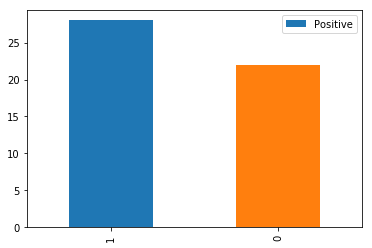

In [11]:
from matplotlib.pyplot import *

ax = df_tweets.Prediction.value_counts().plot(kind = "bar")
ax.legend(["Positive","Negative"],loc='upper right')

### Connect webpage and Model

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [10/Nov/2020 08:34:07] "GET / HTTP/1.1" 200 -


An exception occurred:  Language does not exist.
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'
Exception 'NoneType' object has no attribute 'group'


127.0.0.1 - - [10/Nov/2020 08:34:13] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [10/Nov/2020 08:34:18] "POST /get_data HTTP/1.1" 302 -


Searching tweets for:  R-filter:retweets-filter:media


127.0.0.1 - - [10/Nov/2020 08:34:20] "GET /success/RUPERT HTTP/1.1" 200 -


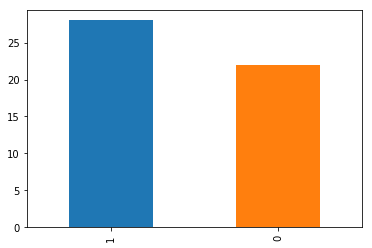

In [12]:
# importing the required libraries
from flask import Flask, render_template, request, redirect, url_for, Response
from flask_table import Table, Col
from joblib import load
from flask import send_file
#import base64
from io import BytesIO
#import io
#import random
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import random, threading, webbrowser


####------function to get trening tweets----####
def gettrends():
    # get the twitter trends
    df_world_trends = get_trends_by_location(1, 10)
    df_world_trends["Translated_Trends"] = [get_translation(val) for val in df_world_trends.Trends]
    return df_world_trends[["Trends","Language","Translated_Trends"]]

####------ function to get results for a particular text query----####
def requestResults(search_keyword):
    # get the tweets text
    df_tweets = get_related_tweets(search_keyword)
    # Predict Emotion for the tweets
    df_tweets = predict_emotion(df_tweets)
    # Clean the tweets
    df_tweets = data_cleaning(df_tweets)

    return df_tweets

####------ function to create a plot ----####
def create_plot():
    fig = Figure()
    img = df_tweets.Prediction.value_counts().plot(kind = "bar")
    return fig
# start flask
app = Flask(__name__)

####------render default webpage ----####
@app.route('/')
def home():
    return render_template('home.html')

# when the post method detect, then redirect to trends page
@app.route('/', methods=['POST', 'GET'])
def get_trends():
    if request.method == 'POST':
        trends = gettrends()
        return render_template('trends.html', table=trends.to_html())


# when the post method detect, create a url for success
@app.route('/get_data', methods=['POST', 'GET'])
def get_data():
    if request.method == 'POST':
        name = request.form['search']
        return redirect(url_for('success', name=name))

    #create a Plot and send a png file
@app.route('/plot_png')
def plot_png():
    fig = create_plot()
    img = BytesIO()
    plt.savefig(img)
    img.seek(0)
    #plot_url = base64.b64encode(img.getvalue())
    return send_file(img, mimetype='image/png')

####------when the post method detect, then redirect to results page
@app.route('/success/<name>')
def success(name):
    #return "<xmp>" + str(requestResults(name)) + " </xmp> "
    results = requestResults(name)
    plot_url = plot_png()
    return render_template('results.html', img=plot_url, table=results.to_html())


if __name__ == '__main__':
    #port = 5000 + random.randint(0, 999)
    #print(port)
    #url = "http://127.0.0.1:{0}".format(port)
    #print(url)
    #app.run(use_reloader=False, debug=True, port=port)
    app.run(use_reloader=False, debug=True)
    